# Analyze models
##### authors: Elizabeth A. Barnes and Noah Diffenbaugh
##### date: March 20, 2022


## Python stuff

In [1]:
import sys, imp, os, copy

import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import tensorflow as tf
import tensorflow_probability as tfp

import scipy.stats as stats
import seaborn as sns

import experiment_settings
import file_methods, plots, data_processing

import matplotlib as mpl
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["figure.dpi"] = 150
savefig_dpi = 300
np.warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [2]:
print(f"python version = {sys.version}")
print(f"numpy version = {np.__version__}")
print(f"xarray version = {xr.__version__}")  
print(f"tensorflow version = {tf.__version__}")  
print(f"tensorflow-probability version = {tfp.__version__}")  

python version = 3.9.7 (default, Sep 16 2021, 08:50:36) 
[Clang 10.0.0 ]
numpy version = 1.22.2
xarray version = 2022.3.0
tensorflow version = 2.7.0
tensorflow-probability version = 0.15.0


## User Choices

In [3]:
EXP_NAME = 'exp0'
PLOT_SEED = 1257

#-------------------------------------------------------

settings = experiment_settings.get_settings(EXP_NAME)
display(settings)

MODEL_DIRECTORY = 'saved_models/'        
PREDICTIONS_DIRECTORY = 'saved_predictions/'
DATA_DIRECTORY = 'data/'
DIAGNOSTICS_DIRECTORY = 'model_diagnostics/'
FIGURE_DIRECTORY = 'figures/'

{'save_model': True,
 'n_models': 10,
 'ssp': '370',
 'gcmsub': 'ALL',
 'obsdata': 'BEST',
 'target_temp': 1.5,
 'n_train_val_test': (7, 2, 1),
 'baseline_yr_bounds': (1850, 1899),
 'training_yr_bounds': (1970, 2100),
 'anomaly_yr_bounds': (1951, 1980),
 'anomalies': True,
 'remove_map_mean': False,
 'network_type': 'shash2',
 'hiddens': [10, 10],
 'dropout_rate': 0.0,
 'ridge_param': [1.0, 0.0],
 'learning_rate': 1e-05,
 'batch_size': 64,
 'rng_seed': 8889,
 'seed': None,
 'act_fun': ['relu', 'relu'],
 'n_epochs': 25000,
 'patience': 50,
 'exp_name': 'exp0'}

## Initial housekeeping

In [4]:
## determine how many GCMs are being used
filenames = file_methods.get_cmip_filenames(settings, verbose=0)
N_GCMS = len(filenames)

# load observations for diagnostics plotting
da_obs, x_obs, global_mean_obs = data_processing.get_observations(DATA_DIRECTORY, settings)
N_TRAIN, N_VAL, N_TEST, ALL_MEMBERS = data_processing.get_members(settings)

observations: filling NaNs with zeros
np.shape(x_obs) = (172, 10368)


## Plotting Functions

In [5]:
FS = 16

### for white background...
# plt.rc('text',usetex=True)
plt.rc('text',usetex=False)
# plt.rc('font',**{'family':'sans-serif','sans-serif':['Avant Garde']}) 
plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']}) 
plt.rc('savefig',facecolor='white')
plt.rc('axes',facecolor='white')
plt.rc('axes',labelcolor='dimgrey')
plt.rc('axes',labelcolor='dimgrey')
plt.rc('xtick',color='dimgrey')
plt.rc('ytick',color='dimgrey')
################################  
################################  
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 5))
        else:
            spine.set_color('none')  
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        ax.yaxis.set_ticks([])
    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        ax.xaxis.set_ticks([]) 

def format_spines(ax):
    adjust_spines(ax, ['left', 'bottom'])
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.spines['left'].set_color('dimgrey')
    ax.spines['bottom'].set_color('dimgrey')
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.tick_params('both',length=4,width=2,which='major',color='dimgrey')
#     ax.yaxis.grid(zorder=1,color='dimgrey',alpha=0.35)    
    

## Load the observations predictions

In [6]:
rng = np.random.default_rng(settings["rng_seed"])
pred_obs_vec = np.zeros(shape=(settings['n_models'], x_obs.shape[0], 2))*np.nan

for iloop in np.arange(settings['n_models']):
    seed = rng.integers(low=1_000,high=10_000,size=1)[0]
    settings["seed"] = int(seed)

    # get model name
    model_name = file_methods.get_model_name(settings)
    filename = PREDICTIONS_DIRECTORY+model_name + '_obs_predictions.pickle'
    if os.path.exists(filename):
        obs_pred_seed = pd.read_pickle(filename)
        pred_obs_vec[iloop,:,0] = obs_pred_seed[:,0] 
        pred_obs_vec[iloop,:,1] = obs_pred_seed[:,1] 
    else:
        print(model_name  +" does not exist. Skipping...") 
        print("================================\n")
        continue    
        #----------------------------------------
        
    if seed == PLOT_SEED:
        obs_pred_plot = copy.deepcopy(obs_pred_seed)
        model_name_plot = copy.deepcopy(model_name)

print("done.")

done.


## Plot spread in $\mu$ across random seeds

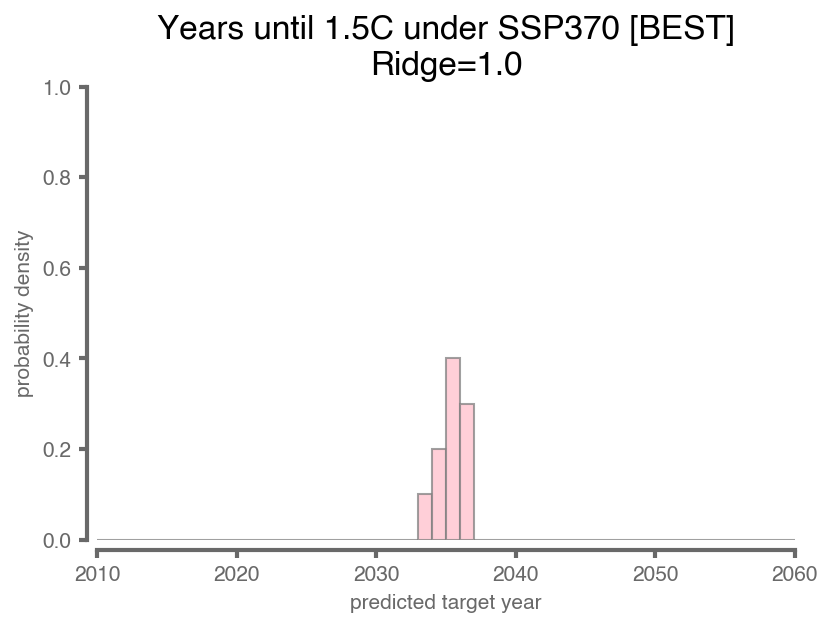

In [7]:
INPUT_YEAR = 2021
iyear = np.where(da_obs["time.year"]==INPUT_YEAR)[0]

perc_low = np.percentile(pred_obs_vec[:,iyear,0],25)
perc_high = np.percentile(pred_obs_vec[:,iyear,0],25)

plt.figure()
plt.hist(INPUT_YEAR+pred_obs_vec[:,iyear,0],
         bins=np.arange(1850,2100),
         color="pink",
         edgecolor='gray',
         alpha=.75,
         density=True,
        )
plt.axvline(x=perc_low,
            linestyle='--',
            color="pink",
           )
plt.axvline(x=perc_high,
            linestyle='--',
            color="pink",            
           )

plt.xticks(np.arange(1850,2100,10),np.arange(1850,2100,10))
plt.yticks(np.arange(0,1.2,.2),np.arange(0,1.2,.2).round(1))
plt.xlim(2010,2060)
plt.ylim(0,1)
plt.xlabel('predicted target year')
plt.ylabel('probability density')

ax = plt.gca()
format_spines(ax)

plt.title('Years until ' + str(settings["target_temp"]) + 'C under SSP' + settings["ssp"] + ' [' + settings["obsdata"] + ']\nRidge=' + str(settings["ridge_param"][0]),
          color='k',
          fontsize=16,
         )

plt.savefig(FIGURE_DIRECTORY + settings["exp_name"] + '_spread_mu' + '.png', 
            bbox_inches="tight",
            dpi=savefig_dpi)
plt.show()

## Plot Single Seed Obs

#### Option A

2022-03-22 11:30:11.950878: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


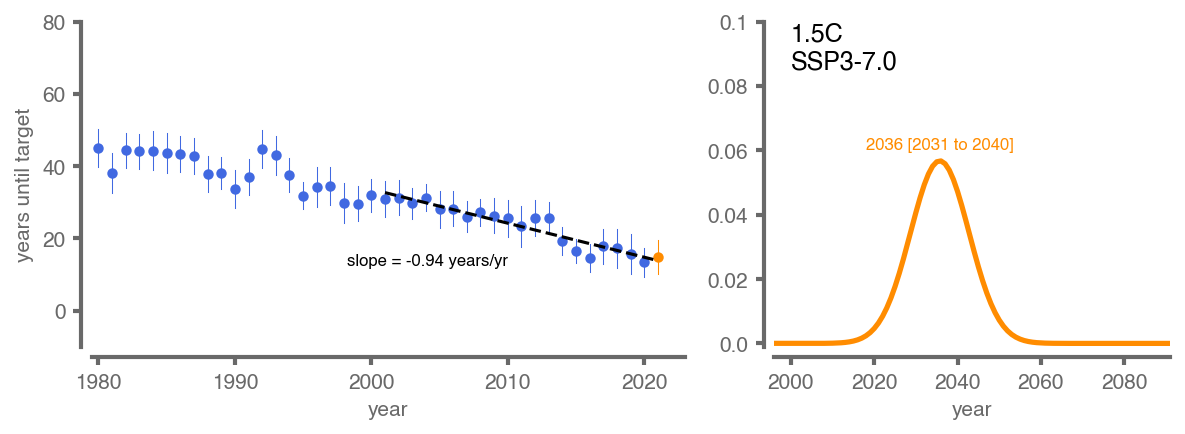

In [8]:
clr_choice = 'darkorange'
y_predict_obs = obs_pred_seed

iy = np.where(da_obs['time.year'].values >= 2001)[0]
x = da_obs['time.year'].values[iy]
y = y_predict_obs[iy,0]
linear_model = stats.linregress(x=x,y=y)

#--------------------------------
norm_incs = np.arange(-80,80,1)
mu_pred = y_predict_obs[:,0]
sigma_pred = y_predict_obs[:,1]
norm_dist = tfp.distributions.Normal(mu_pred,sigma_pred)
norm_perc_low = norm_dist.quantile(.25).numpy()   
norm_perc_high = norm_dist.quantile(.75).numpy()      
norm_perc_med = norm_dist.quantile(.5).numpy()      
norm_cpd = norm_dist[-1].prob(norm_incs)
y_predict_obs = norm_perc_med

pred_text = (str(int(mu_pred[-1].round(0)+2021)) + 
             ' [' + str(int(norm_perc_low[-1].round(0)+2021)) + 
             ' to ' + str(int(norm_perc_high[-1].round(0)+2021)) + 
             ']'
            )

#------------------------------------------------------------
ax = plt.subplots(1,2,figsize=(8,3),gridspec_kw={'width_ratios': [3, 2]})
years = np.arange(1850,2022)

plt.subplot(1,2,1)
for iyear in np.arange(0,y_predict_obs.shape[0]):
    min_val = norm_perc_low[iyear]
    med_val = norm_perc_med[iyear]
    max_val = norm_perc_high[iyear]

    # clr = 'lightseagreen'
    if(years[iyear]==2021):
        clr = clr_choice
    else:
        clr = 'royalblue'
    
    plt.plot(years[iyear],
             med_val,
             'o',
             markersize=4,
             color=clr,
            )
    # comment out the plotting line below if you don't want 
    # error bars
    plt.plot((years[iyear],years[iyear]),(min_val, max_val),
             linestyle='-',
             linewidth=.5,
             color=clr,
            )

plt.plot(x,x*linear_model.slope+linear_model.intercept,'--', color='black')
plt.text(2010,
         norm_perc_med[-1]*.8,
         'slope = ' + str(linear_model.slope.round(2)) + ' years/yr',         
         horizontalalignment="right",
         verticalalignment="bottom",
         color='k',
         fontsize=8,
        )

plt.xticks(np.arange(1850,2100,10),np.arange(1850,2100,10))
plt.yticks(np.arange(-100,100,20),np.arange(-100,100,20).round(0))
plt.ylabel('years until target')
plt.xlabel('year')

plt.xlim(1979.5,2023)    
plt.ylim(-10,80)
format_spines(plt.gca())

#---------------------------------------------------------------
# plot PDF

plt.subplot(1,2,2)
plt.plot(norm_incs+2021,
         norm_cpd,
         linewidth=2.5,
         color=clr_choice,
        )
         

k = np.argmin(np.abs(norm_perc_low[-1]-norm_incs))
# plt.plot((norm_perc_low[-1]+2021,norm_perc_low[-1]+2021),(0,norm_cpd[k]),'--',color=clr_choice)
k = np.argmin(np.abs(norm_perc_high[-1]-norm_incs))
# plt.plot((norm_perc_high[-1]+2021,norm_perc_high[-1]+2021),(0,norm_cpd[k]),'--',color=clr_choice)

plt.text(mu_pred[-1]+2021,
         np.max(norm_cpd)*1.05,
         pred_text,         
         horizontalalignment="center",
         verticalalignment="bottom",
         color=clr_choice,
         fontsize=8,
        )
if(settings["target_temp"]==1.1):
    plt.text(norm_perc_high[-1]+2021+10,
             np.max(norm_cpd)*0.35,
             '2021',
             fontsize=16,
             horizontalalignment="left",
             verticalalignment="bottom",
             color=clr_choice, 
             weight="bold",
            )

plt.text(2000,
         .1,
         str(settings["target_temp"]) + "C\nSSP" + settings["ssp"][0] + '-' + settings["ssp"][1] + '.' + settings["ssp"][-1],
         fontsize=12,
         horizontalalignment="left",
         verticalalignment="top",
         color='k', 
         # weight="bold",
        )
         
plt.xlabel('year')
# plt.title('Predictions for ' + settings["obsdata"] + ' Observations under SSP' + settings["ssp"] + '\nYear = 2021')
plt.xticks(np.arange(-101,100,20)+2021,np.arange(-101,100,20)+2021)
plt.yticks(np.arange(0,.12,.02),np.arange(0,.12,.02).round(2))
# plt.yticks([])

plt.xlim(-25+2021,70+2021)
plt.ylim(-0.001,.1)
format_spines(plt.gca())
# plt.gca().spines['left'].set_color(None)

plt.tight_layout()
plt.savefig(FIGURE_DIRECTORY + model_name_plot + '_obs_timeseries_spread' + '.png', 
            bbox_inches="tight",
            dpi=savefig_dpi)
plt.show()

## Analyze CMIP results

In [9]:
rng = np.random.default_rng(settings["rng_seed"])
settings["seed"] = PLOT_SEED

# get model name
model_name = file_methods.get_model_name(settings)

# load the model
model = file_methods.load_tf_model(model_name, MODEL_DIRECTORY)

# get the data
(x_train, 
 x_val, 
 x_test, 
 y_train, 
 y_val, 
 y_test, 
 onehot_train, 
 onehot_val, 
 onehot_test, 
 y_yrs_train, 
 y_yrs_val, 
 y_yrs_test, 
 target_years, 
 map_shape,
 settings) = data_processing.get_cmip_data(DATA_DIRECTORY, settings)


[0 4 2 1 8 9 7] [6 5] [3]
tas_Amon_historical_ssp370_CanESM5_r1-10_ncecat_ann_mean_2pt5degree.nc
TARGET_YEAR = 2011
tas_Amon_historical_ssp370_ACCESS-ESM1-5_r1-10_ncecat_ann_mean_2pt5degree.nc
TARGET_YEAR = 2035
tas_Amon_historical_ssp370_UKESM1-0-LL_r1-10_ncecat_ann_mean_2pt5degree.nc
TARGET_YEAR = 2024
tas_Amon_historical_ssp370_MIROC-ES2L_r1-10_ncecat_ann_mean_2pt5degree.nc
TARGET_YEAR = 2038
tas_Amon_historical_ssp370_GISS-E2-1-G_r1-10_ncecat_ann_mean_2pt5degree.nc
TARGET_YEAR = 2029
tas_Amon_historical_ssp370_IPSL-CM6A-LR_r1-10_ncecat_ann_mean_2pt5degree.nc
TARGET_YEAR = 2020
tas_Amon_historical_ssp370_CESM2-LE2-smbb_r1-10_ncecat_ann_mean_2pt5degree.nc
TARGET_YEAR = 2030
---------------------------
data_train.shape = (49, 131, 72, 144)
data_val.shape = (14, 131, 72, 144)
data_test.shape = (7, 131, 72, 144)
(6419, 10368) (6419,) (6419,)
(1834, 10368) (1834,) (1834,)
(917, 10368) (917,) (917,)


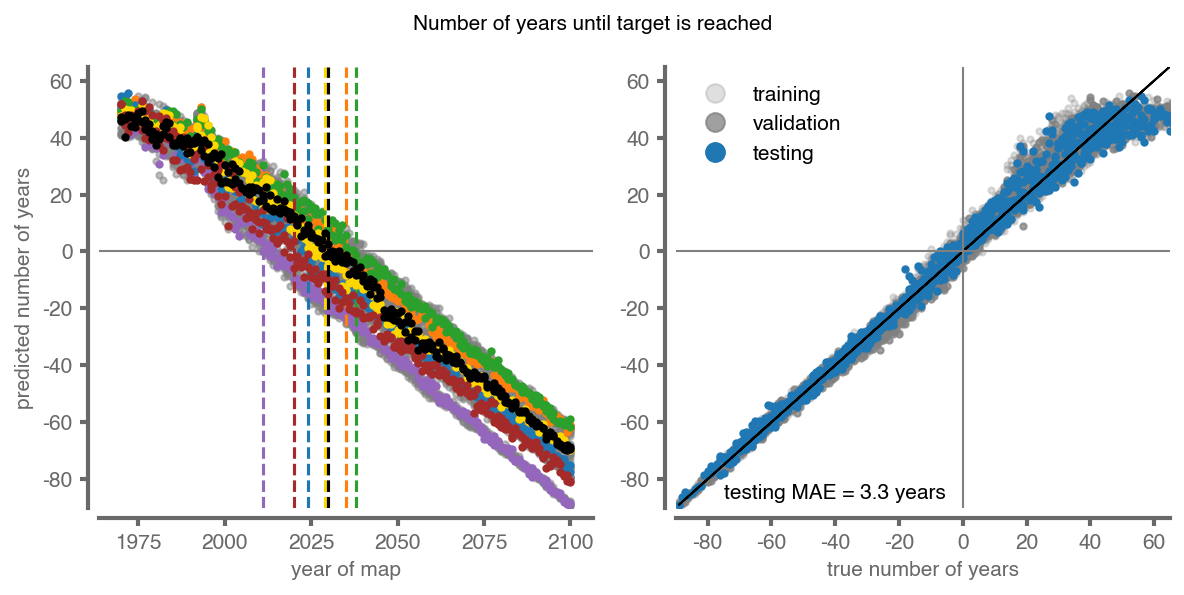

In [28]:
top_pred_idx = 0

YEARS_UNIQUE = np.unique(y_yrs_train)
predict_train = model.predict(x_train)[:,top_pred_idx].flatten()
predict_val = model.predict(x_val)[:,top_pred_idx].flatten()
predict_test = model.predict(x_test)[:,top_pred_idx].flatten()
mae = np.mean(np.abs(predict_test-y_test[:]))

#--------------------------------
clr = ('tab:purple','tab:orange', 'tab:blue', 'tab:green', 'gold', 'brown','black','darkorange')
plt.subplots(1,2,figsize=(8,4))

plt.subplot(1,2,1)
plt.plot(y_yrs_train, predict_train,'.',color='gray',alpha=.5, label='training')
# plt.title('Time to Target Year for ' + str(settings['target_temp']) + 'C using ssp' + str(settings['ssp']))
plt.xlabel('year of map')
plt.ylabel('predicted number of years')
plt.yticks(np.arange(-80,100,20),np.arange(-80,100,20))
plt.ylim(-90,65)
plt.axhline(y=0, color='gray', linewidth=1)
format_spines(plt.gca())



predict_val_mat = predict_val.reshape(N_GCMS,N_VAL,len(YEARS_UNIQUE))
for i in np.arange(0,predict_val_mat.shape[0]):
    plt.plot(YEARS_UNIQUE, predict_val_mat[i,:,:].swapaxes(1,0),'.', label='validation', color=clr[i])
    plt.axvline(x=target_years[i],linestyle='--',color=clr[i])

plt.subplot(1,2,2)
plt.plot(y_train, predict_train,'.',color='gray',alpha=.25, label='training')
plt.plot(y_val, predict_val,'.', label='validation',color='gray',alpha=.75,)
plt.plot(y_test, predict_test,'.', label='testing')    
plt.plot(y_train,y_train,'-',color='k',linewidth=1)
plt.axvline(x=0,color='gray',linewidth=1)
plt.axhline(y=0,color='gray',linewidth=1)
# plt.title('Testing MAE = ' + str(mae.round(2)) + ' years')
plt.xlabel('true number of years')
plt.ylabel(None)
plt.legend(fontsize=10,frameon=False,markerscale=3.)

plt.xticks(np.arange(-80,100,20),np.arange(-80,100,20))
plt.yticks(np.arange(-80,100,20),np.arange(-80,100,20))
plt.xlim(-90,65)
plt.ylim(-90,65)

plt.text(-75,
         -85,
         'testing MAE = ' + str(mae.round(1)) + ' years',
         fontsize=10,
         horizontalalignment="left",
         verticalalignment="center",
         color='k', 
         # weight="bold",
        )


plt.suptitle('Number of years until target is reached',fontsize=10)
format_spines(plt.gca())

plt.tight_layout()
plt.savefig(FIGURE_DIRECTORY + model_name_plot + '_cmip_validation_scatter' + '.png', 
            bbox_inches="tight",
            dpi=savefig_dpi)
plt.show()
